In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
from diffusers import DDPMPipeline
from PIL import Image
from torchvision import transforms
from diffusers import UNet2DModel
from accelerate import Accelerator
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from diffusers.utils import make_image_grid

c:\Users\caspe\anaconda3\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\caspe\anaconda3\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
dataset = load_dataset("huggan/selfie2anime", split="train")
print(dataset)

Dataset({
    features: ['imageA', 'imageB'],
    num_rows: 3400
})


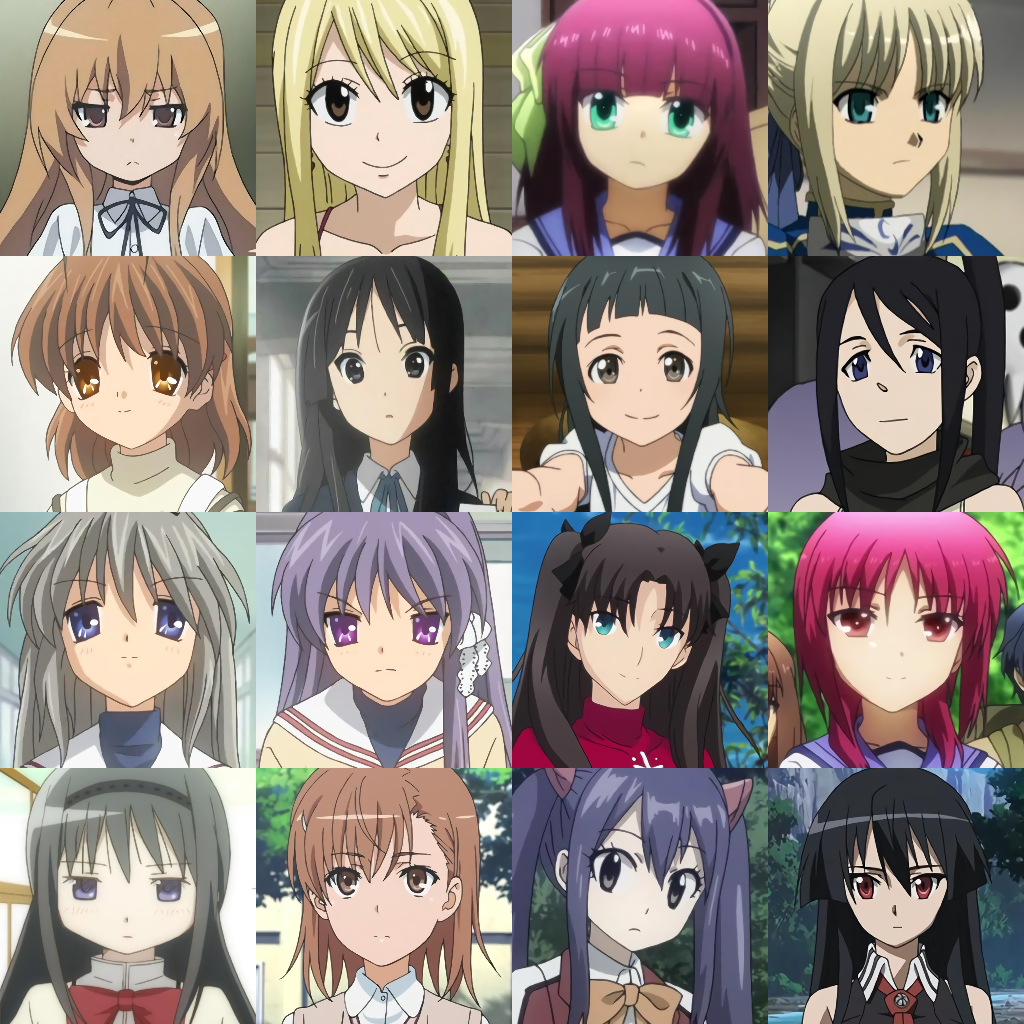

In [4]:
make_image_grid(dataset["imageB"][:16], rows=4, cols=4)

In [3]:
class Noise_schedule:
    def __init__(self,noise_steps=1000,beta_start=1e-4,beta_end=0.02,image_size=64,device='cuda'):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = image_size
        self.device = device

        self.beta = torch.linspace(self.beta_start,beta_end,self.noise_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha,dim=0)

class DoubleConv(nn.Module):
    def __init__(self,in_c,out_c,mid_channels=None,residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_c
        self.doubleConv = nn.Sequential(
            nn.Conv2d(in_c,mid_channels,3,padding=1,bias=False),
            nn.GroupNorm(1,mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels,out_c,3,padding=1,bias=False),
            nn.GroupNorm(1,out_c)
        )
    
    def forward(self,x):
        if self.residual:
            return F.gelu(x + self.doubleConv(x))
        else:
            return self.doubleConv(x)

class SelfAttention(nn.Module):
    def __init__(self,c,size):
        super().__init__()
        self.c = c
        self.size = size
        self.mha = nn.MultiheadAttention(c,4,batch_first=True)
        self.norm = nn.LayerNorm([c])
        self.feedforward = nn.Sequential(
            nn.LayerNorm([c]),
            nn.Linear(c,c),
            nn.GELU(),
            nn.Linear(c,c)
        )
    
    def forward(self,x):
        x = x.view(-1,self.c,self.size * self.size).swapaxes(1,2)
        x_norm = self.norm(x)
        attn,_ = self.mha(x_norm,x_norm,x_norm)
        attn = attn + x
        attn = self.feedforward(attn) + attn
        return attn.swapaxes(2,1).view(-1,self.c,self.size,self.size)

class Down(nn.Module):
    def __init__(self,in_c,out_c,emb_dim=256):
        super().__init__()
        self.max_pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c,in_c,residual=True),
            DoubleConv(in_c,out_c)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim,out_c) # (1,256) --> (1,out_c) ?
        )
    
    def forward(self,x,t):
        x = self.max_pool_conv(x)
        emb = self.emb_layer(t)[:,:,None,None].repeat(1,1,x.shape[-2],x.shape[-1]) # (1,c) --> (1,c,,) --> (1,c,out_c,out_c) ?
        return x + emb # (1,c,out_c,out_c)

class Up(nn.Module):
    def __init__(self,in_c,out_c,emb_dim=256):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c,in_c//2,2,stride=2)
        self.conv = nn.Sequential(
            DoubleConv(in_c,in_c,residual=True),
            DoubleConv(in_c,out_c,in_c // 2)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim,out_c) # (1,256) --> (1,3) ?
        )

    def forward(self,x,skip,t):
        x = self.up(x) # (1,c,x,x) --> (1,c,x*2,x*2) ?
        x = torch.cat([skip,x],dim=1) # (1,c*2,x*2,x*2) ?
        x = self.conv(x)
        emb = self.emb_layer(t)[:,:,None,None].repeat(1,1,x.shape[-2],x.shape[-1]) # (1,c) --> (1,c,,) --> (1,c,out_c,out_c) ?
        return x + emb

class Config():
    def __init__(self,in_channels,sample_size):
        self.in_channels = in_channels
        self.sample_size = sample_size

class UNet(nn.Module):
    def __init__(self,c_in=3,c_out=3,time_dim=256,device='cuda'):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.config = Config(3,128)


        #### CHANGE SA SIZES ACCORDING TO IMAGE SIZE
        self.first_layer = DoubleConv(c_in,64)
        self.down1 = Down(64,128)
        self.SA1 = SelfAttention(128,64)
        self.down2 = Down(128,256)
        self.SA2 = SelfAttention(256,32)
        self.down3 = Down(256,512)
        self.SA3 = SelfAttention(512,16)

        self.bottle = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(512,1024)
        )

        self.up1 = Up(1024,512)
        self.SA4 = SelfAttention(512,16)
        self.up2 = Up(512,256)
        self.SA5 = SelfAttention(256,32)
        self.up3 = Up(256,128)
        self.SA6 = SelfAttention(128,64)
        self.last_layer = Up(128,64)

        self.out = nn.Conv2d(64,c_out,kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq) # (1,time_dim // 2)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq) # (1,time_dim // 2)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)          # (1,time_dim)
        return pos_enc
    
    def forward(self,x,t):
        t = t.unsqueeze(-1).type(torch.float)  # (1,)
        t = self.pos_encoding(t,self.time_dim) # (1,time_dim)

        x1 = self.first_layer(x)
        x2 = self.down1(x1,t)
        # x2 = self.SA1(x2)
        x3 = self.down2(x2,t)
        # x3 = self.SA2(x3)
        x4 = self.down3(x3,t)
        x4 = self.SA3(x4)

        x5 = self.bottle(x4)

        x6 = self.up1(x5,x4,t)
        x6 = self.SA4(x6)
        x7 = self.up2(x6,x3,t)
        # x7 = self.SA5(x7)
        x8 = self.up3(x7,x2,t)
        # x8 = self.SA6(x8)
        x9 = self.last_layer(x8,x1,t)

        return self.out(x9)

In [4]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 200
LR = 1e-3
LR_WARMUP_STEPS = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
MODEL_SAVE_DIR = "anime-128-own-unet"

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])
def transform(examples):
    images = [preprocess(image) for image in examples["imageB"]]
    return {"images":images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

model = UNet().to(device)
ns = Noise_schedule(image_size=IMAGE_SIZE,device=device)

optimizer = torch.optim.AdamW(model.parameters(),lr=LR)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=LR_WARMUP_STEPS,
    num_training_steps=(len(train_dataloader)*NUM_EPOCHS)
)
accelerator = Accelerator(
    mixed_precision="fp16",
    log_with="tensorboard",
    project_dir=os.path.join(MODEL_SAVE_DIR,"logs")
)

if accelerator.is_main_process:
    if MODEL_SAVE_DIR is not None:
        os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    accelerator.init_trackers("train_example")

model,optimizer,train_dataloader,lr_scheduler,ns = accelerator.prepare(model,optimizer,train_dataloader,lr_scheduler,ns)

cuda


In [5]:
from re import X


def sample(model,noise_schedule,n):
    model.eval()
    with torch.no_grad():
        x = torch.randn((n,3,noise_schedule.img_size,noise_schedule.img_size)).to(noise_schedule.device)
        for i in tqdm(reversed(range(1,noise_schedule.noise_steps)),position=0):
            t = (torch.ones(n) * i).long().to(noise_schedule.device)
            pred_noise = model(x,t)
            alpha = noise_schedule.alpha[t][:,None,None,None]
            alpha_hat = noise_schedule.alpha_hat[t][:,None,None,None]
            beta = noise_schedule.beta[t][:,None,None,None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * pred_noise) + torch.sqrt(beta) * noise
    model.train()
    x = (x.clamp(-1,1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1,2,0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

def noise_images(x,t,noise_schedule):
    sqrt_alpha_hat = torch.sqrt(noise_schedule.alpha_hat[t])[:,None,None,None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - noise_schedule.alpha_hat[t])[:,None,None,None]
    eps = torch.randn_like(x)
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

In [6]:
global_step = 0
SAVE_ARTIFACT_EPOCHS = 5
RANDOM_SEED = 42

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=len(train_dataloader),disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # noise = torch.randn(clean_images.shape,device=clean_images.device)
        batch_size = clean_images.shape[0]

        timesteps = torch.randint(0,ns.noise_steps,(batch_size,),device=clean_images.device,dtype=torch.int64)
        x_t, noise = noise_images(clean_images,timesteps,ns)
        # noisy_images = noise_scheduler.add_noise(clean_images,noise,timesteps)
        

        with accelerator.accumulate(model):
            noise_pred = model(x_t,timesteps)
            loss= F.mse_loss(noise_pred,noise)
            accelerator.backward(loss)
            accelerator.clip_grad_norm_(model.parameters(),1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr":lr_scheduler.get_last_lr()[0],"step":global_step}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs,step=global_step)
        global_step += 1
    
    if accelerator.is_main_process:
        if (epoch+1) % SAVE_ARTIFACT_EPOCHS == 0 or epoch == NUM_EPOCHS-1:
            sampled_images = sample(model,ns,16)
            test_dir = os.path.join(MODEL_SAVE_DIR,"samples")
            os.makedirs(test_dir,exist_ok=True)
            save_images(sampled_images,os.path.join(test_dir,f"{epoch}.jpg"))

Epoch 3: 100%|██████████| 213/213 [00:41<00:00,  5.19it/s, loss=0.022, lr=0.000852, step=851]
999it [00:49, 20.05it/s]| 213/213 [00:39<00:00,  5.57it/s, loss=0.0299, lr=0.001, step=1064]  
Epoch 8: 100%|██████████| 213/213 [00:39<00:00,  5.40it/s, loss=0.0112, lr=0.000999, step=1916] 
999it [00:49, 20.09it/s]
Epoch 13: 100%|██████████| 213/213 [00:39<00:00,  5.35it/s, loss=0.0234, lr=0.000994, step=2981]
999it [00:49, 20.09it/s]█| 213/213 [00:39<00:00,  5.52it/s, loss=0.0174, lr=0.000993, step=3194] 
Epoch 18: 100%|██████████| 213/213 [00:39<00:00,  5.39it/s, loss=0.0231, lr=0.000987, step=4046] 
999it [00:49, 20.09it/s]
Epoch 23: 100%|██████████| 213/213 [00:39<00:00,  5.35it/s, loss=0.0719, lr=0.000976, step=5111]
999it [00:49, 20.09it/s]█| 213/213 [00:39<00:00,  5.55it/s, loss=0.0173, lr=0.000974, step=5324] 
Epoch 28: 100%|██████████| 213/213 [00:39<00:00,  5.39it/s, loss=0.0053, lr=0.000962, step=6176] 
999it [00:49, 20.06it/s]
Epoch 33: 100%|██████████| 213/213 [00:39<00:00,  5.3

: 